configuration:
models_ver - insert YOLO version's numbers that the UAP will be trained on.

epsilon, lambda_1, lambda_2 - attack's parameters. more information can be found in the [paper](https://arxiv.org/abs/2205.13618)

BDD_IMG_DIR - a path to the BDD validation set images (or any other wanted dataset)

BDD_LAB_DIR - a path to the BDD validation set labels (or any other wanted dataset)

In [9]:
models_vers = [5] # for example: models_vers = [5] or models_vers = [3, 4, 5]
epsilon = 70
lambda_1 = 1
lambda_2 = 10
seed = 42
patch_size=(640,640)
img_size=(640,640)
batch_size = 8
num_workers = 4
max_labels_per_img = 65
BDD_IMG_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val'
BDD_LAB_DIR = '/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/labels/val'

Load BDD dataset:

In [10]:
import torch
import os
import random
import numpy

from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import SplitDatasetCombined_BDD

In [11]:
# batch = [(1, 'a'), (2, 'b'), (3, 'c')]

# unzipped = zip(*batch)

# numbers, letters = unzipped

# print(numbers)  # Output: (1, 2, 3)
# print(letters)  # Output: ('a', 'b', 'c')

#dus ipv [(tensor, array, string), (tensor, array, string), (tensor, array, string)] hebben we
# train_loader[0] bevat 8 images
# train_loader[1] bevat alle labels per voor 8 images
# train_loader[2] bevat paths naar 8 images
def collate_fn(batch):
    return tuple(zip(*batch))

def set_random_seed(seed_value, use_cuda=True):
    numpy.random.seed(seed_value)  # cpu vars
    torch.manual_seed(seed_value)  # cpu  vars
    random.seed(seed_value)  # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python hash buildin
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [12]:
split_dataset = SplitDatasetCombined_BDD(
            img_dir= BDD_IMG_DIR,
            lab_dir= BDD_LAB_DIR,
            max_lab=max_labels_per_img,
            img_size=img_size,
            transform=train_transform,
            collate_fn=collate_fn)

In [13]:
#train_loader en val_loader 

#train loader bevat een tuple van 3, elk element van de tuple bevat 8 samples (8 samples maakt 1 batch)
#De tuple bestaat uit het volgende:
    #[0] = de image met size (3,640,640)
    #[1] = de bounding boxes met size (x, 5) (5 bestaat uit class, x, y, x, y)
        #lijkt nergens gebruikt te worden
    #[2] = de naam van de image (e.g. 'c98258a4-54a47ff2.jpg')  

    #HEB IK AL DEZE INFORMATIE OOK NODIG WANNEER IK WIL TESTEN OP PASCAL/MTSD? converten is een pain
        #WORDT [2] ERGENS GEBRUIKT? IK WEET DAT [1] NERGENS GEBRUIKT WORDT
train_loader, val_loader, test_loader = split_dataset(val_split=0.1,
                                                      shuffle_dataset=True,
                                                      random_seed=seed,
                                                      batch_size=batch_size,
                                                      ordered=False,
                                                      collate_fn=collate_fn)

In [19]:
# from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler

# sampler = RandomSampler([0,1,2,3])

# for i in sampler:
#     print(i)

In [20]:
# next(iter(train_loader))

In [21]:
# clean_xyxy_out = torch.tensor([[0.0156, 0.0312, 0.0781, 0.1094]])

# patch_xyxy_out = torch.tensor([
#                         [10/640, 20/640, 50/640, 70/640],  # [x1, y1, x2, y2]
#                         [30/640, 40/640, 80/640, 100/640],
#                         [60/640, 70/640, 120/640, 160/640],
#                     ])

# #intersect(patch_xyxy_out, clean_xyxy_out)

# torch.min(clean_xyxy_out[:, 2:].unsqueeze(1).expand(1, 3, 2), patch_xyxy_out[:, 2:].unsqueeze(0).expand(1, 3, 2))

In [22]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image

# # Load the image using PIL
# image = Image.open('/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd100k/images/100k/val/b1c9c847-3bda4659.jpg')

# # Define the transformations to apply to the image
# transform = transforms.ToTensor()

# # Apply the transformations to convert the image to a tensor
# tensor = transform(image)

In [23]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# # Inference
# results = model(tensor.unsqueeze(0))

In [24]:
# results.size()

In [25]:
# for (img_batch, lab_batch, _) in val_loader:
#     print(torch.stack(img_batch).size())
#     break


create UAP:

In [237]:
import numpy
from attack.uap_phantom_sponge import UAPPhantomSponge

torch.cuda.empty_cache()

patch_name = r"yolov"
for ver in models_vers:
  patch_name += f"_{ver}"
patch_name += f"_epsilon={epsilon}_lambda1={lambda_1}_lambda2={lambda_2}"

uap_phantom_sponge_attack = UAPPhantomSponge(patch_folder=patch_name, 
                                             train_loader=train_loader, 
                                             val_loader=val_loader, 
                                             epsilon = epsilon, 
                                             lambda_1=lambda_1, 
                                             lambda_2=lambda_2, 
                                             #epochs=7,#stond hier voorheen nog niet
                                             patch_size=patch_size, 
                                             models_vers=models_vers)
adv_img = uap_phantom_sponge_attack.run_attack()

Fusing layers... 
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


CUDA Available:  False
local_yolos/yolov5/weights/yolov5s.pt
Epoch:  0
saving png of current patch at epoch: 0, batch: 0/169...
combined_loss, max_obj, bb_area, iou_loss for this batch =               0.353|0.249|0.01|0.0
combined_loss, max_obj, bb_area, iou_loss for this batch =               0.336|0.248|0.009|0.002


KeyboardInterrupt: 

# CODE FOR EVALUATION

In [14]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
from local_yolos.yolov5.models.experimental import attempt_load
from local_yolos.yolov5.utils.general import non_max_suppression
from torchvision import transforms
from local_yolos.yolov5.utils.metrics import box_iou
from local_yolos.yolov5.utils.plots import Annotator
import time
from tqdm import tqdm

In [15]:
# Load the YOLOv5 model
model = attempt_load(weights='yolov5s.pt').eval()

Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
yolov5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


yolov5s.pt


In [17]:
def perturb_img(img_name, change_aspect_ratio = True, output_type = "torch"):
    image_path = "/Users/coenschoof/miniconda/envs/phantomsponges/BDD100K-to-YOLOV5/bdd_in_YOLOV5_train_newLabels/images/val/" + img_name
    image = Image.open(image_path)
    image = image.resize((640, 640))
    transform = transforms.Compose([transforms.ToTensor()])
    clean_img = transform(image)

    # Load the image using PIL
    patch_path =  "/Users/coenschoof/miniconda/envs/phantomsponges/PhantomSponges/final_patch_new_loss_term.png"
    patch = Image.open(patch_path)
    patch = transform(patch)

    perturbed_img = torch.clamp(clean_img + patch, 0, 1)

    # Assuming you have a torch tensor named torch_image
    # You can resize the tensor to (H, W, C) shape using transpose and multiply by 255 (if it's not already in the correct range)
    #pil_image = transforms.ToPILImage()(result.squeeze().cpu() * 255)
    tensor_min = torch.min(perturbed_img)
    tensor_max = torch.max(perturbed_img)
    normalized_tensor = (perturbed_img - tensor_min) / (tensor_max - tensor_min)

    # Convert the normalized tensor to a PIL image
    pil_image = transforms.ToPILImage()(normalized_tensor.squeeze().cpu())
    if change_aspect_ratio:
        random_scale_w = random.uniform(0.7, 0.9) #1.5, 3
        #random_scale_h = random.uniform(1, 2.5)
        width = int(640 * random_scale_w)
        width = (width // 32) * 32 #ensures that the new width is a multiple of 32, otherwise the model does not work
        height = 640 #height = int(640 * random_scale_h)
        height = (height // 32) * 32
        pil_image = pil_image.resize((width, height))

    if output_type == "torch":
        perturbed_image = transform(pil_image)
    elif output_type == "numpy":
        perturbed_image = np.array(pil_image)
    elif output == "pil":
        pass
    else:
        print("Unsupported output type provided!")

    return(perturbed_image)

(640, 640, 3)


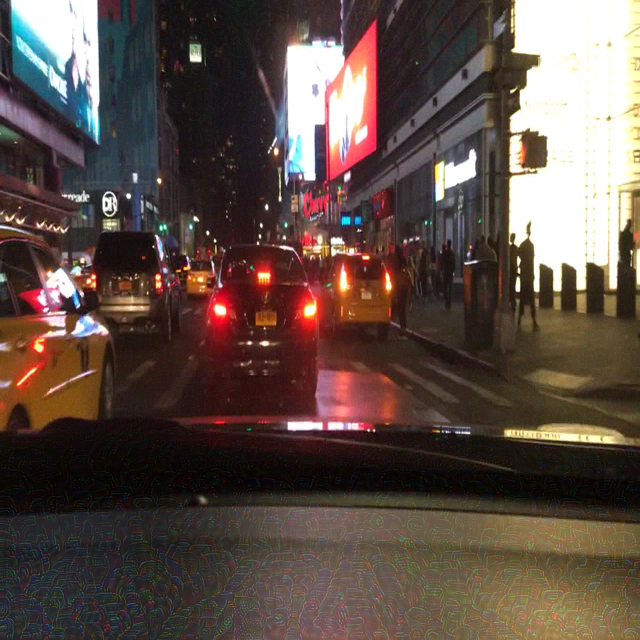

In [18]:
some_image = perturb_img('b1ca2e5d-84cf9134.jpg', change_aspect_ratio = False, output_type = "numpy")
print(some_image.shape)
pil_image = transforms.ToPILImage()(some_image.squeeze())
display(pil_image)

In [19]:
image_names = []
for image_np, _, image_name in tqdm(test_loader):
    image_names.append(image_name[0])

100%|██████████| 500/500 [00:07<00:00, 68.58it/s]


In [20]:
# for img_name in tqdm(image_names):
#     other_image = perturb_img(img_name, change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
#     pil_image = transforms.ToPILImage()(other_image.squeeze())
#     pil_image.save(f"clean_images/{img_name}.jpg")

100%|██████████| 500/500 [00:28<00:00, 17.55it/s]


In [20]:
def compute_recall(box_iou_output):
    true_pos = 0
    for clean_detection in box_iou_output:
        if clean_detection[clean_detection > 0.45].nelement() != 0:
            true_pos += 1

    return true_pos / box_iou_output.size()[0]

In [21]:
def add_bbs(image, xyxys):
    numpy_clean_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    annotator = Annotator(np.ascontiguousarray(numpy_clean_img))
    
    for xyxy in xyxys:
        annotator.box_label(xyxy)
    annotator_results = annotator.result()
    annotator_results = (annotator_results * 255).astype(np.uint8)
    pil_image = Image.fromarray(annotator_results)

    return pil_image

In [22]:
def scale_bbs(orig_dims, target_dims, orig_xyxy):
    # Original image dimensions (640x1200)
    original_height, original_width = orig_dims[2:]

    # Target image dimensions (640x640)
    target_height, target_width = target_dims[2:]

    # Calculate scaling factors for x and y dimensions
    x_scale = target_width / original_width
    y_scale = target_height / original_height

    # Scale the coordinates of the bounding boxes
    scaled_bounding_boxes = orig_xyxy.clone().detach()  # Create a copy to preserve the original data
    scaled_bounding_boxes[:, 0] *= x_scale  # Scale x (left)
    scaled_bounding_boxes[:, 1] *= y_scale  # Scale y (top)
    scaled_bounding_boxes[:, 2] *= x_scale  # Scale x2 (right)
    scaled_bounding_boxes[:, 3] *= y_scale  # Scale y2 (bottom)

    return scaled_bounding_boxes

In [23]:
def evaluate_results(loader = test_loader, Tconf = 0.25, Tiou = 0.45, max_det_pert=300, max_det_clean=300):
    all_total_times = []
    all_nms_times = []
    all_num_bbs_before_nms = []
    all_recalls = []

    for image_np, _, image_name in tqdm(loader):
        perturbed_img = perturb_img(image_name[0],change_aspect_ratio = True).unsqueeze(0)
        #print(image_name[0])
        #print("perturbed img size: ", perturbed_img.shape)
        clean_img = image_np[0].unsqueeze(0)
        #print("clean img size: ", clean_img.shape)

        total_times_single_img = []
        nms_times_single_img = []

        #for i in range(30):
        start_time_1 = time.time() * 1000
        output_perturbed = model(perturbed_img)[0]
        start_time_2 = time.time() * 1000
        keep_perturbed = non_max_suppression(output_perturbed, Tconf, Tiou, classes=None,max_det=max_det_pert)
        #print(len(keep_perturbed[0]))
        end_time = time.time() * 1000 
        total_time = end_time - start_time_1
        nms_time = end_time - start_time_2
        total_times_single_img.append(total_time)
        nms_times_single_img.append(nms_time)
        
        #total_time = sum(total_times_single_img) / len(total_times_single_img)
        #nms_time = sum(nms_times_single_img) / len(nms_times_single_img)

        output_clean = model(clean_img)[0]
        keep_clean = non_max_suppression(output_clean, Tconf, Tiou, classes=None,max_det=max_det_clean)

        num_bbs_before_nms_mask = output_perturbed[..., 4] > Tconf 
        num_bbs_before_nms = num_bbs_before_nms_mask.sum().item()   #F(C')

        clean_xyxy = keep_clean[0][:,0:4]
        #print(clean_xyxy)

        # with_bbs = add_bbs(clean_img, clean_xyxy)
        # display(with_bbs)
        perturbed_xyxy = keep_perturbed[0][:,0:4]

        # with_bbs = add_bbs(perturbed_img, perturbed_xyxy)
        # display(with_bbs)


        #scaled_perturbed_xyxy = scale_coords(perturbed_img.shape[2:], perturbed_xyxy, clean_img.shape[2:]).round()
        scaled_perturbed_xyxy = scale_bbs(orig_dims=perturbed_img.shape, target_dims=clean_img.shape, orig_xyxy = perturbed_xyxy)

        # resized_perturbed_img = F.interpolate(perturbed_img, size=(640,640), mode='bilinear', align_corners=False)
        # with_bbs = add_bbs(resized_perturbed_img, scaled_perturbed_xyxy)
        # display(with_bbs)

        box_iou_output = box_iou(clean_xyxy, scaled_perturbed_xyxy)
        
        #check if its the case that there aren't any clean detections
        #in that case, skip computing the recall
        #"the number of original objects detected in the perturbed image"
        #if there aren't any original objects, no recall can be calculated, thus we skip
        if clean_xyxy.nelement() != 0:
            recall = compute_recall(box_iou_output)
            all_recalls.append(recall)


        all_total_times.append(total_time)
        all_nms_times.append(nms_time)
        all_num_bbs_before_nms.append(num_bbs_before_nms)
        
    avg_total_time = sum(all_total_times) / len(all_total_times)
    avg_nms_time = sum(all_nms_times) / len(all_nms_times)
    avg_num_bbs_before_nms = sum(all_num_bbs_before_nms) / len(all_num_bbs_before_nms)
    avg_recall = sum(all_recalls) / len(all_recalls)

    return round(avg_total_time, 1), round(avg_nms_time, 1), round(avg_num_bbs_before_nms), round(avg_recall, 3)

results = evaluate_results()

  0%|          | 2/500 [00:02<11:58,  1.44s/it]


KeyboardInterrupt: 

In [92]:
results

#dit zijn de results met resize breedte tussen de 0.7 en 0.9
#super! De inference time is omlaag gegaan, de nms time is 5 keer zo klein, het aantal bbs voor nms is superklein, en de recall is prima

(397.3, 0.8, 207, 0.667)

In [78]:
results

#dit zijn de results met resize breedte tussen de 0.5 en 0.9
#het lijkt te kloppen dat kleinere plaatjes leidt tot een lagere inference time, helaas is de recall ook omlaag gegaan
#smallere range proberen


(338.9, 0.6, 116, 0.531)

In [16]:
results

#HET WERKT!!!!!!
#WAAROM IS DE INFERENCE TIME ZO LANG? MISSCHIEN OMDAT DE PLAATJES GROTER ZIJN? (MEER WAARDEN TE VERWERKEN DOOR HET MODEL)
#PROBEER TE RUNNEN MET EEN RESIZE FACTOR <1
#MSS OOK PROBEREN TE RUNNEN MET EEN RESIZED HOOGTE IPV BREEDTE

(1436.1, 1.8, 247, 0.72)

In [714]:
#dit zijn de resultaten zonder resize
results

(504.1, 4.3, 4499, 0.656)

In [412]:
#dit zijn de resultaten zonder resize, met nieuwe loss term
results

(438.6, 1.1, 308, 0.656)

# New loss term experiments

### TO DO
blijkbaar 

In [149]:
import torchvision
from local_yolos.yolov5.utils.general import non_max_suppression, xyxy2xywh

In [80]:
# def bboxes_area_on_steroids(output_clean, output_patch, conf_thres=0.25):

#     def xywh2xyxy(x):
#         # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
#         y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
#         y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
#         y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
#         y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
#         y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
#         return y

#     t_loss = 0.0
#     xc_patch = output_patch[..., 4] > conf_thres
#     not_nan_count = 0

#     # For each img in the batch
#     for (xi, x) in enumerate(output_patch):  # image index, image inference
#         #neem alle BBs waarvan de confidence hoger is dan 0.25
#         x1 = x[xc_patch[xi]]  
#         #als de output 0 BBs bevat, skip deze iteratie dan
#         if x1.numel() == 0:
#             print("YOLO could not find any BBs on this image")
#             continue
#         #x1 heeft nu een size van [21420, 85], (batch_size, num_predictions, pred_elements)
#         #pred_elements is 85 lang, de eerste 4 zijn BB coords, 5 is conf score, overige 80 zijn class probs
#         #hieronder worden dus de class probs vermenigvuldigd met de conf score
#         x2 = x1[:, 5:] * x1[:, 4:5]  
#         #print(x2.shape)

#         # Box (center x, center y, width, height) to (x1, y1, x2, y2)
#         box_x1 = xywh2xyxy(x1[:, :4])
#         #print(box_x1)
#         min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height

#         #neemt over alle boxes de hoogste confwaarden, en de index daarvan (dus 1 confwaarde per box)
#         conf_x1, j_x1 = x2.max(1, keepdim=True)
#         #concateneer de xyxy waarden met de hoogste conf, en de daarbij horende index van de conf
#         #indexeer die vervolgens weer met waar de conf > 0.25
#         #print(torch.cat((box_x1, conf_x1, j_x1.float()), 1).shape)
#         #print(torch.cat((box_x1, conf_x1, j_x1.float()), 1)[conf_x1.view(-1) > conf_thres].shape)
#         x1_full = torch.cat((box_x1, conf_x1, j_x1.float()), 1)[conf_x1.view(-1) > conf_thres]
#         #print(x1_full)
#         boxes_x1 = x1_full[:, :4]
#         print(boxes_x1.size)
#         iou = box_iou(boxes_x1, boxes_x1)
#         print(iou.dtype, boxes_x1.dtype)
#         mask = torch.triu(torch.ones(iou.shape[0], iou.shape[1]), diagonal=1)
#         upper_triangular_tensor = iou[mask.bool()]
#         #print(upper_triangular_tensor)
#         img_loss = upper_triangular_tensor.sum() / len(upper_triangular_tensor)

#         t_loss += img_loss
#         not_nan_count += 1

#     if not_nan_count == 0:
#         t_loss_f = torch.tensor(torch.nan)
#     else:
#         t_loss_f = t_loss / not_nan_count

#     return t_loss_f

In [146]:
def bboxes_area_on_steroids(output_clean, output_patch, conf_thres=0.25):
    def xywh2xyxy(x):
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2
        y[:, 1] = x[:, 1] - x[:, 3] / 2
        y[:, 2] = x[:, 0] + x[:, 2] / 2
        y[:, 3] = x[:, 1] + x[:, 3] / 2
        return y

    def box_area(box):
        # box = xyxy(4,n)
        return (box[2] - box[0]) * (box[3] - box[1])

    def box_iou(box1, box2):
        # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            box1 (Tensor[N, 4])
            box2 (Tensor[M, 4])
        Returns:
            iou (Tensor[N, M]): the NxM matrix containing the pairwise
                IoU values for every element in boxes1 and boxes2
        """

        # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
        (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
        inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

        # IoU = inter / (area1 + area2 - inter)
        return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter)

    t_loss = 0.0
    not_nan_count = 0

    with torch.no_grad():
        # For each img in the batch
        for (xi, x) in enumerate(output_patch):  # image index, image inference
            # Filter out predictions with confidence below the threshold
            xc_patch = x[..., 4] > conf_thres
            x1 = x[xc_patch]

            if x1.numel() == 0:
                print("YOLO could not find any BBs on this image")
                continue

            # Extract relevant information from predictions
            x2 = x1[:, 5:] * x1[:, 4:5]
            box_x1 = xywh2xyxy(x1[:, :4])
            print(box_x1.shape)

            # Calculate IoU only for valid predictions
            iou = box_iou(box_x1, box_x1)#.to(torch.float16)
            mask = torch.triu(torch.ones(iou.shape[0], iou.shape[1]), diagonal=1)
            upper_triangular_tensor = iou[mask.bool()]

            if upper_triangular_tensor.numel() > 0:
                img_loss = upper_triangular_tensor.sum() / len(upper_triangular_tensor)
                t_loss += img_loss
                not_nan_count += 1

    if not_nan_count == 0:
        t_loss_f = torch.tensor(torch.nan)
    else:
        t_loss_f = t_loss / not_nan_count

    return t_loss_f, iou


In [147]:
zeros_tensor = torch.zeros(1, 3, 640, 640)
zero_output = model(zeros_tensor)[0]

random_index = random.randrange(len(image_names))
other_image = perturb_img(image_names[random_index], change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
random_index = random.randrange(len(image_names))
other_image_2 = perturb_img(image_names[random_index], change_aspect_ratio = False, output_type = "torch").unsqueeze(0)
pil_image = transforms.ToPILImage()(other_image.squeeze())
#display(pil_image)

tiny_batch = torch.cat((other_image, other_image_2, zeros_tensor))
tiny_batch_output = model(tiny_batch)

In [148]:
box, iou = bboxes_area_on_steroids(tiny_batch_output[0], tiny_batch_output[0])

torch.Size([4081, 4])
torch.Size([1198, 4])
YOLO could not find any BBs on this image


In [143]:
box

tensor(0.00524)

In [145]:
iou.shape

torch.Size([3489, 3489])

In [71]:
# import itertools

# def box_iou(boxes):
#     # Calculate the IoU between every pair of bounding boxes in 'boxes', excluding self-overlaps.
#     # Input 'boxes' is expected to be in the format xyxy(n, 4),
#     # where each row represents a bounding box in the format [x1, y1, x2, y2].

#     num_boxes = boxes.shape[0]
#     iou_list = []

#     for i, j in itertools.combinations(range(num_boxes), 2):
#         box1 = boxes[i]
#         box2 = boxes[j]

#         # Compute the intersection area
#         lt = torch.max(box1[:2], box2[:2])
#         rb = torch.min(box1[2:], box2[2:])
#         wh = (rb - lt).clamp(min=0)
#         inter = wh[0] * wh[1]

#         # Compute the areas of the bounding boxes
#         area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
#         area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

#         # Calculate IoU
#         iou = inter / (area1 + area2 - inter)
#         iou_list.append(iou.item())

#     return iou_list


# Experiments for removal of phantom bounding boxes post-NMS

In [157]:
tiny_batch_output[0].shape

torch.Size([3, 25200, 85])

In [167]:
from sklearn.cluster import DBSCAN

In [199]:
for image_np, _, image_name in tqdm(test_loader):
    perturbed_img = perturb_img(image_name[0],change_aspect_ratio = True).unsqueeze(0)
    #clean_img = image_np[0].unsqueeze(0)

    output_perturbed = model(perturbed_img)[0]
    keep_perturbed = non_max_suppression(output_perturbed, 0.25, 0.45, classes=None,max_det=300)


    data_np = keep_perturbed[0].numpy()
    # Define the DBSCAN clustering model
    eps = 0.5  # Maximum distance between two samples to be considered in the same neighborhood
    min_samples = 2  # Minimum number of samples in a neighborhood to form a core point
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # Fit the DBSCAN model to the data
    labels = dbscan.fit_predict(data_np)
    # The 'labels' array contains the cluster assignments for each data point
    print(labels)
    print(data_np)

    
    break

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[[     271.41      378.25      284.04      413.73     0.52768           9]
 [     440.94      508.14      461.28      533.88      0.4787           9]
 [     233.52      588.06      291.98      639.69     0.44399           2]
 [     186.16      568.83      217.14      607.08      0.4277           2]
 [     148.28      548.21      177.05      592.84     0.37595           2]
 [     454.41      601.24      479.92      639.85     0.37469           2]
 [     144.65      322.55      159.76      367.03     0.36978           9]
 [     419.34         601      452.96      639.85     0.30435           2]
 [     123.51      545.33       173.4       598.2     0.27767           2]
 [     466.34      610.43      480.21      640.07     0.26915           2]
 [     72.325      596.81      98.443      638.54     0.25709           2]
 [     455.54      565.31      479.88         599     0.25108           2]
 [     58.052      600.58      82.047      638.94     0.250